In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.brain as fob
from tqdm.notebook import tqdm, trange
from PIL import Image
import matplotlib.pyplot as plt
import torchsummary
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist
# import resnet18 model from pytorch
from torchvision.models import resnet18
from torch.utils.tensorboard import SummaryWriter
import mxnet as mx
from mxnet import recordio
import torch.multiprocessing as mp
from sklearn.model_selection import train_test_split
from collections import defaultdict
import logging
import cv2
from facenet_pytorch import MTCNN

In [2]:
DIM = (112, 112)
BS = 256
EPOCHS = 30
LR = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4
NUM_CLASSES = 10572
NUM_WORKERS = 4
LOG_INTERVAL = 6

In [3]:
# Initialize the MTCNN face detector
mtcnn = MTCNN(keep_all=False, device='cuda:1')

# Function to perform face detection and crop face from image
def detect_and_crop_face(image, mtcnn, preprocess):
    # Convert image to PIL format if it's not already
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)
    elif isinstance(image, torch.Tensor):
        print("Converting torch tensor to PIL image")
        image = transforms.ToPILImage()(image)
    elif not isinstance(image, Image.Image):
        raise ValueError("Input image must be a numpy array, torch tensor, or PIL Image.")
    # Ensure the image is in RGB format
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    # Detect face bounding box using MTCNN
    # Note: mtcnn.detect returns boxes and probabilities.
    boxes, _ = mtcnn.detect(image)
    
    if boxes is not None:
        # Optionally choose the first detected face (or the one with highest score)
        box = boxes[0]
        # Crop the face using the bounding box and ensure it's in integer format
        cropped_face = image.crop((int(box[0]), int(box[1]), int(box[2]), int(box[3])))
        # You might want to add some padding or handle multiple faces based on your use-case.
    else:
        # If no face is detected return the original image or handle accordingly
        print(f"No face detected in. Using the original image.")
        cropped_face = image  # Convert to CxHxW format for PyTorch

    # Preprocess the cropped image
    # cropped_face = apply_clahe_pil(cropped_face, gray=False)
    return preprocess(cropped_face)

In [4]:
# class CASIAWebFaceDataset(Dataset):
#     def __init__(self, path_imgrec, transform=None):
#         self.transform = transform
#         assert path_imgrec
#         if path_imgrec:
#             logging.info('loading recordio %s...',
#                          path_imgrec)
#             path_imgidx = path_imgrec[0:-4] + ".idx"
#             print(path_imgrec, path_imgidx)
#             self.imgrec = recordio.MXIndexedRecordIO(path_imgidx, path_imgrec, 'r')
#             s = self.imgrec.read_idx(0)
#             header, _ = recordio.unpack(s)
#             if header.flag > 0:
#                 print('header0 label', header.label)
#                 self.header0 = (int(header.label[0]), int(header.label[1]))
#                 # assert(header.flag==1)
#                 # self.imgidx = range(1, int(header.label[0]))
#                 self.imgidx = []
#                 self.id2range = {}
#                 self.seq_identity = range(int(header.label[0]), int(header.label[1]))
#                 for identity in self.seq_identity:
#                     s = self.imgrec.read_idx(identity)
#                     header, _ = recordio.unpack(s)
#                     a, b = int(header.label[0]), int(header.label[1])
#                     count = b - a
#                     self.id2range[identity] = (a, b)
#                     self.imgidx += range(a, b)
#                 print('id2range', len(self.id2range))
#             else:
#                 self.imgidx = list(self.imgrec.keys)
#             self.seq = self.imgidx

#     def __getitem__(self, idx):
#         # Map global index to class ID and local index
#         actual_idx = idx + 1  # MXNet indices start from 1
        
#         # Read record
#         header, s = recordio.unpack(self.imgrec.read_idx(actual_idx))
#         img = mx.image.imdecode(s).asnumpy()
#         label = int(header.label)
        
#         # # Convert to PIL and apply transforms
#         img = Image.fromarray(img)
#         if self.transform:
#             img = self.transform(img)
        
#         return img, label

#     def __len__(self):
#         return len(self.seq)

In [5]:
class CASIAWebFaceDataset(Dataset):
    def __init__(self, path_dataset, transform=None):
        self.transform = transform
        # the dataset is a folder with subfolders. The subfolder name is the label,
        # and the images are in the subfolder. Images represent their index in dataset.
        self.imgs = []
        self.labels = []
        
        # get all subfolders in the dataset folder
        subfolders = [f.path for f in os.scandir(path_dataset) if f.is_dir()]
        # get all images in the subfolders
        for label, subfolder in enumerate(subfolders):
            for img_file in os.listdir(subfolder):
                if img_file.endswith('.jpg') or img_file.endswith('.png'):
                    self.imgs.append(os.path.join(subfolder, img_file))
                    self.labels.append(label)
        self.imgs = np.array(self.imgs)
        self.labels = np.array(self.labels)
        self.seq = np.arange(len(self.imgs))
        self.id2range = defaultdict(list)
        for i, label in enumerate(self.labels):
            self.id2range[label].append(i)
        self.seq_identity = np.unique(self.labels)
        self.imgidx = np.arange(len(self.imgs))

    def __getitem__(self, idx):
        # Map global index to class ID and local index
        actual_idx = idx
        
        # Read image
        img = Image.open(self.imgs[actual_idx])
        label = int(self.labels[actual_idx])
        
        # Convert to PIL and apply transforms
        if self.transform:
            img = self.transform(img)
        
        return img, label
    def __len__(self):
        return len(self.seq)
    def get_imgidx(self):
        return self.imgidx

In [6]:
class CustomNormalize:
    def __call__(self, img):
        # Convert PIL image to tensor
        img = transforms.ToTensor()(img)
        # Subtract 128 and divide by 128
        img = (img * 255.0 - 127.5) / 128.0
        return img

class Cutout(object):
    """Randomly masks out one or more patches from an image.

    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).

        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1:y2, x1:x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

train_preprocess = transforms.Compose([
    transforms.RandomResizedCrop(DIM, scale=(0.08, 1.0)),  # Randomly crop the image to the specified size
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(30),  # Randomly rotate the image by up to 10 degrees
    # transforms.RandomVerticalFlip(),  # Randomly flip the image vertically
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Randomly change brightness, contrast, saturation and hue
    CustomNormalize(),
    # Cutout(n_holes=1, length=16),  # Randomly cut out a square patch
])

test_preprocess = transforms.Compose([
    transforms.Resize(DIM),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    CustomNormalize()
])

Dataset size:  490623
Number of classes:  10572


Converting torch tensor to PIL image


No face detected in. Using the original image.
torch.Size([1, 3, 112, 112]) tensor([10367])


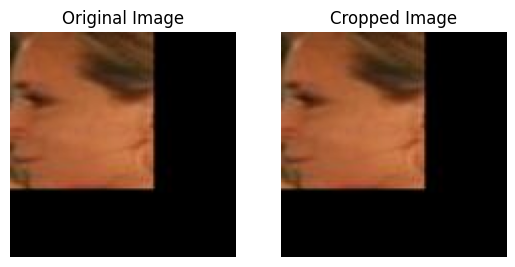

In [7]:
# get a sample from dataset
# dataset = CASIAWebFaceDataset(path_imgrec='./faces_webface_112x112/train.rec', transform=transforms.Compose([
#     transforms.ToTensor(),
# ]))
dataset = CASIAWebFaceDataset(path_dataset='./faces_webface_112x112_cropped', transform=transforms.Compose([
    transforms.ToTensor(),
]))
print("Dataset size: ", len(dataset))
print("Number of classes: ", len(dataset.seq_identity))

loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=NUM_WORKERS)
img, label = next(iter(loader))
cropped_face = detect_and_crop_face(img[0], mtcnn, transforms.Compose([
    transforms.Resize(DIM),
    transforms.ToTensor(),
]))
imgage = img[0].permute(1, 2, 0)
# imgage = Cutout(n_holes=1, length=16)(imgage)
print(img.size(), label)
# plot both images
plt.subplot(1, 2, 1)
plt.imshow(imgage)
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cropped_face.permute(1, 2, 0).cpu().numpy())
plt.title("Cropped Image")
plt.axis('off')
plt.show()
# print(cropped_face.size())


# assert False


In [8]:
class AMSoftmax(nn.Module):
    '''
    The am softmax as seen on https://arxiv.org/pdf/1801.05599.pdf,

        in_features: size of the embedding, eg. 512
        n_classes: number of classes on the classification task
        s: s parameter of loss, standard = 30.
        m: m parameter of loss, standard = 0.4, best between 0.35 and 0.4 according to paper.

        *inputs: tensor shaped (batch_size X embedding_size)
        output : tensor shaped (batch_size X n_classes) AM_softmax logits for NLL_loss.

    '''
    def __init__(self, in_features, n_classes, s=30, m=0.35):
        super(AMSoftmax, self).__init__()
        self.linear = nn.Linear(in_features, n_classes, bias=False)
        self.s = s
        self.m = m

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, *inputs):
        # x_vector = F.normalize(inputs[0], p=2, dim=-1)
        # self.linear.weight.data = F.normalize(self.linear.weight.data, p=2, dim=-1, eps=1e-10)
        # logits = self.linear(x_vector)
        x_vector = inputs[0]
        normed_weight = F.normalize(self.linear.weight, p=2, dim=-1, eps=1e-10)
        logits = F.linear(x_vector, normed_weight)
        scaled_logits = (logits - self.m)*self.s
        return  scaled_logits - self._am_logsumexp(logits)

    def _am_logsumexp(self, logits):
        '''
        logsumexp designed for am_softmax, the computation is numerically stable

        '''
        max_x = torch.max(logits, dim=-1)[0].unsqueeze(-1)
        term1 = (self.s*(logits - (max_x + self.m))).exp()
        term2 = (self.s * (logits - max_x)).exp().sum(-1).unsqueeze(-1) \
                - (self.s * (logits - max_x)).exp()
        return self.s*max_x + (term2 + term1).log()
    

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # self.relu = nn.PReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out


# How can I modify the model to output embeddings of size 128?
# 1. Create a new model that outputs embeddings
# 2. Modify the last layer of the model to output embeddings
# 3. Use a hook to extract embeddings from the model
# 4. Use a custom loss function to train the model

class ResNet18(nn.Module):
    def __init__(self, num_classes=10572, dropout=0.4):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(dropout)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        self.dropout(out)
        out = self.fc(out)
        out = F.normalize(out, p=2, dim=-1, eps=1e-10)
        return out


In [9]:
def test_classifier(model, classifier, data_loader, device, message):
    model.eval()
    classifier.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            embeddings = model(images)  # Extract features
            logits = classifier(embeddings)  # Compute AMSoftmax logits
            predictions = torch.argmax(logits, dim=1)  # Get class with max probability
            
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total * 100
    print(f"✅ Classification Accuracy for {message}: {accuracy:.2f}%")
    return accuracy

In [10]:
def train_AMSoftmax(model: nn.Module, classifier: nn.Module, data_loader: DataLoader, val_loader: DataLoader,
                    optimizer: optim.Optimizer, scheduler: optim.lr_scheduler, 
                    criterion: nn.Module, epochs: int, device: torch.device, 
                    retain_graph: bool, checkpoint_interval: int = 10):

    train_losses = []
    tmstmp = time.strftime("%Y%m%d-%H%M%S")
    best_loss = np.inf
    vacc = 0

    # tmstmp = "20250313-074759"

    log_dir = f"runs/{DIM[0]}x{DIM[1]}_ResNet18_AMSoftmax_{tmstmp}"
    writer = SummaryWriter(log_dir=log_dir)

    print(f"Started Training at {tmstmp}")
    
    for e, epoch in enumerate(tqdm(range(epochs), desc="Epochs")):
        model.train()
        classifier.train()
        running_loss = 0.0
        for i, (images, labels) in enumerate(tqdm(data_loader, desc="Batches")):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            embeddings = model(images)  # Extract embeddings from model
            logits = classifier(embeddings)  # Compute AMSoftmax logits
            loss = criterion(logits, labels)  # Compute NLL loss

            loss.backward(retain_graph=retain_graph)
            optimizer.step()
            running_loss += loss.item()
            # print(f"Batch {i+1}/{len(data_loader)} - Loss: {loss.item():.4f}")

        scheduler.step()
        avg_loss = running_loss / len(data_loader)
        train_losses.append(avg_loss)

        # Validation
        model.eval()
        classifier.eval()
        running_loss = 0.0
        with torch.no_grad():
            for i, (images, labels) in enumerate(tqdm(val_loader, desc="Validation")):
                images, labels = images.to(device), labels.to(device)
                embeddings = model(images)
                logits = classifier(embeddings)
                loss = criterion(logits, labels)
                running_loss += loss.item()
            # print(f"Batch {i+1}/{len(val_loader)} - Loss: {loss.item():.4f}")


        # Log per epoch
        writer.add_scalar('Loss/train', avg_loss, epoch)
        writer.add_scalar('Loss/val', running_loss / len(val_loader), epoch)

        # Checkpoint saving
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_path = os.path.join(log_dir, f'checkpoint_epoch_{epoch + 1}.pth')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'classifier_state_dict': classifier.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            }, checkpoint_path)
            print(f"Checkpoint saved at {checkpoint_path}")
            train_acc = test_classifier(model, classifier, data_loader, device, "Training")
            val_acc = test_classifier(model, classifier, val_loader, device, "Validation")
            writer.add_scalar('Accuracy/train', train_acc, epoch)
            writer.add_scalar('Accuracy/val', val_acc, epoch)
            if val_acc > vacc:
                vacc = val_acc
                torch.save(model.state_dict(), f"{log_dir}/{DIM[0]}x{DIM[1]}_ResNet18_AMSoftmax_validation_{tmstmp}.pt")
                print(f"Saved best model with validation accuracy {vacc}")
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")
        # Save Best Model
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), f"{log_dir}/{DIM[0]}x{DIM[1]}_ResNet18_AMSoftmax_{tmstmp}.pt")
            print(f"Saved best model with loss: {best_loss:.4f}")

    print(f"Finished Training at {time.strftime('%Y%m%d-%H%M%S')} with best validation accuracy {vacc:.4f}")
    writer.close()

    return model, train_losses, tmstmp

In [11]:
def train_on_casia_webface(embedding_model, classifier, optimizer, device, device_ids):
    # Set up paths
    # rec_path = "/home/ichitu/py-files/faces_webface_112x112/train.rec"
    path_dataset = "/home/ichitu/py-files/faces_webface_112x112_cropped"

    
    # Load datasets
    print("Loading CASIA WebFace dataset...")
    # casia_dataset = CASIAWebFaceDataset(
    #     path_imgrec=rec_path,
    #     transform=train_preprocess
    # )

    casia_dataset = CASIAWebFaceDataset(
        path_dataset=path_dataset,
        transform=train_preprocess
    )

    train_idx, test_idx = train_test_split(range(len(casia_dataset)), test_size=0.2, random_state=42)
    train_dataset = torch.utils.data.Subset(casia_dataset, train_idx)
    test_dataset = torch.utils.data.Subset(casia_dataset, test_idx)
    # val_idx, test_idx = train_test_split(test_idx, test_size=0.7, random_state=42)
    # val_dataset = torch.utils.data.Subset(casia_dataset, val_idx)
    # test_dataset = torch.utils.data.Subset(casia_dataset, test_idx)

    print(len(train_dataset))
    # print(len(val_dataset))
    print(len(test_dataset))

    

    print(len(casia_dataset))
    
    # print("Loading LFW dataset...")
    # lfw_dataset = foz.load_zoo_dataset("lfw")
    
    # Find and filter overlapping identities
    # print("Finding overlapping identities...")
    # overlapping_ids = find_overlapping_identities(casia_dataset, lfw_dataset)
    
    # print("Creating filtered dataset...")
    # filtered_dataset = FilteredCASIADataset(casia_dataset, overlapping_ids)
    # filtered_dataset = casia_dataset
    
    # Create data loader
    # train_loader = DataLoader(
    #     train_dataset, 
    #     batch_size=BS * len(device_ids),
    #     shuffle=True, 
    #     num_workers=2,
    #     pin_memory=True
    # )

    # val_loader = DataLoader(
    #     val_dataset, 
    #     batch_size=BS * len(device_ids),
    #     shuffle=True, 
    #     num_workers=2,
    #     pin_memory=True
    # )

    # test_loader = DataLoader(
    #     test_dataset, 
    #     batch_size=BS * len(device_ids),
    #     shuffle=True, 
    #     num_workers=2,
    #     pin_memory=True
    # )

    train_loader = DataLoader(
        casia_dataset,
        batch_size=BS,
        num_workers=4,
        sampler=torch.utils.data.SubsetRandomSampler(train_idx),
        pin_memory=True
    )

    # val_loader = DataLoader(
    #     CASIAWebFaceDataset(
    #         path_imgrec=rec_path,
    #         transform=test_preprocess
    #     ),
    #     batch_size=BS,
    #     num_workers=2,
    #     sampler=torch.utils.data.SubsetRandomSampler(val_idx),
    #     pin_memory=True
    # )

    test_loader = DataLoader(
        # CASIAWebFaceDataset(
        #     path_imgrec=rec_path,
        #     transform=test_preprocess
        # ),
        casia_dataset,
        batch_size=BS,
        num_workers=2,
        sampler=torch.utils.data.SubsetRandomSampler(test_idx),
        pin_memory=True
    )
    
    # Set up model
    print("Setting up model...")
    
    # Set up optimizer (include both models' parameters)
    optimizer = optim.SGD(
        list(embedding_model.parameters()) + list(classifier.parameters()),
        lr=LR,
        momentum=MOMENTUM,
        weight_decay=WEIGHT_DECAY
    )
    # optimizer = optim.Adam(
    #     embedding_model.parameters(),
    #     lr=0.001,
    #     weight_decay=5e-4,
    #     eps=1e-8
    # )
    # optimizer = optim.SGD(
    #     list(embedding_model.parameters()) + list(classifier.parameters()),
    #     lr=optimizer['param_groups'][0]['lr'],
    #     momentum=MOMENTUM,
    # weight_decay=WEIGHT_DECAY
    # )

    # Set up scheduler
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-5)
    # scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=10, eta_min=1e-5)
    scheduler = optim.lr_scheduler.MultiStepLR( optimizer, 
                                                milestones=[int(EPOCHS*0.5), int(EPOCHS*0.8), int(EPOCHS*0.9)],
                                                gamma=0.1)
    # Set up loss
    criterion = nn.NLLLoss()
    
    # Train
    print("Starting training...")
    model, losses, timestamp = train_AMSoftmax(
        model=embedding_model,
        classifier=classifier,
        data_loader=train_loader,
        # val_loader=val_loader,
        val_loader=test_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        criterion=criterion,
        epochs=EPOCHS,  # Adjust as needed
        device=device,
        retain_graph=False,
        checkpoint_interval=LOG_INTERVAL
    )

    print("Testing model...")
    test_acc = test_classifier(embedding_model, classifier, test_loader, device, "Test")
    
    return model, losses, timestamp, test_acc

In [12]:
def train_on_casia_webface_normal_split(embedding_model, classifier, optimizer, device, device_ids):
    # Set up paths
    # rec_path = "/home/ichitu/py-files/faces_webface_112x112/train.rec"
    path_dataset = "/home/ichitu/py-files/faces_webface_112x112_cropped"
    
    # Load datasets
    print("Loading CASIA WebFace dataset...")
    # casia_dataset = CASIAWebFaceDataset(
    #     path_imgrec=rec_path,
    #     transform=test_preprocess
    # )
    casia_dataset = CASIAWebFaceDataset(
        path_dataset=path_dataset,
        transform=train_preprocess
    )

    train_length = int(len(casia_dataset) * 0.8)
    test_length = len(casia_dataset) - train_length
    train_dataset, test_dataset = torch.utils.data.random_split(casia_dataset, [train_length, test_length])

    train_loader = DataLoader(
        train_dataset,
        batch_size=BS,
        num_workers=4,
        pin_memory=True,
        shuffle=True
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=BS,
        num_workers=4,
        pin_memory=True,
        shuffle=True
    )
   
    # Set up model
    print("Setting up model...")
    
    # Set up optimizer (include both models' parameters)
    optimizer = optim.SGD(
        list(embedding_model.parameters()) + list(classifier.parameters()),
        lr=LR,
        momentum=MOMENTUM,
        weight_decay=WEIGHT_DECAY
    )
    # optimizer = optim.Adam(
    #     embedding_model.parameters(),
    #     lr=0.001,
    #     weight_decay=5e-4,
    #     eps=1e-8
    # )
    # optimizer = optim.SGD(
    #     list(embedding_model.parameters()) + list(classifier.parameters()),
    #     lr=optimizer['param_groups'][0]['lr'],
    #     momentum=MOMENTUM,
    # weight_decay=WEIGHT_DECAY
    # )

    # Set up scheduler
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-5)
    # scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=10, eta_min=1e-5)
    scheduler = optim.lr_scheduler.MultiStepLR( optimizer, 
                                                milestones=[int(EPOCHS*0.5), int(EPOCHS*0.8), int(EPOCHS*0.9)],
                                                gamma=0.1)
    # Set up loss
    criterion = nn.NLLLoss()
    
    # Train
    print("Starting training...")
    model, losses, timestamp = train_AMSoftmax(
        model=embedding_model,
        classifier=classifier,
        data_loader=train_loader,
        # val_loader=val_loader,
        val_loader=test_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        criterion=criterion,
        epochs=EPOCHS,  # Adjust as needed
        device=device,
        retain_graph=False,
        checkpoint_interval=LOG_INTERVAL
    )

    print("Testing model...")
    test_acc = test_classifier(embedding_model, classifier, test_loader, device, "Test")
    
    return model, losses, timestamp, test_acc

In [13]:
def load_model(model, classifier, check_point_dir, device='cuda'):
    check_point = torch.load(check_point_dir, map_location=device)
    state_dict = check_point['model_state_dict']
    # Create new OrderedDict without 'module.' prefix
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if k.startswith('module.'):
            name = k[7:] # remove 'module.' prefix
        else:
            name = k
        new_state_dict[name] = v
    
    # Load the weights
    model.load_state_dict(new_state_dict)
    # Set to evaluation mode
    # model.eval()
    # print(f"Model loaded from {path}")
    state_dict = check_point['classifier_state_dict']
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if k.startswith('module.'):
            name = k[7:] # remove 'module.' prefix
        else:
            name = k
        new_state_dict[name] = v
    # Load the weights
    classifier.load_state_dict(new_state_dict)

    optimizer = torch.load(check_point_dir, map_location=device)['optimizer_state_dict']

    return model, classifier, optimizer

In [14]:
# assert 1==2

check_point_dir = "/home/ichitu/py-files/runs/112x112_ResNet18_AMSoftmax_20250401-182809/checkpoint_epoch_30.pth"

device_ids = [[2],[2]]
device = torch.device("cuda:{}".format(device_ids[0][0]) if torch.cuda.is_available() else "cpu")
classifier = AMSoftmax(512, 10572)
# embedding_model = EmbeddingResNet18(512)
embedding_model = ResNet18(512)
# embedding_model = Resface20(512)
# embedding_model, classifier, optimizer = load_model(embedding_model, classifier, check_point_dir, device)
# embedding_model = load_model(embedding_model, '/home/ichitu/py-files/runs/112x96_ResNet18_AMSoftmax_20250322-161021/112x96_ResNet18_AMSoftmax_20250322-161021.pt', 'cuda:3')

if torch.cuda.device_count() > 1:
    print(f"Avaible {torch.cuda.device_count()} GPUs and using {device_ids}")
    embedding_model = nn.DataParallel(embedding_model, device_ids=device_ids[0])
    classifier = nn.DataParallel(classifier, device_ids=device_ids[1])

# embedding_model = embedding_model.to(device)
# classifier = classifier.to(device)
# embedding_model.load_state_dict(torch.load("Models-pt/112x96_ResNet18_AMSoftmax_20250313-074759.pt"))
# print(embedding_model)
# print(classifier)
# print(optimizer)
# # assert False

optimizer = torch.load(check_point_dir, map_location=device)['optimizer_state_dict']

embedding_model, train_losses, tmstmp, test_acc = train_on_casia_webface(embedding_model, classifier, optimizer, device, device_ids)

# embedding_model, train_losses, tmstmp, test_acc = train_on_casia_webface_normal_split(embedding_model, classifier, optimizer, device, device_ids)


Avaible 4 GPUs and using [[2], [2]]


Loading CASIA WebFace dataset...


392498
98125
490623
Setting up model...
Starting training...
Started Training at 20250403-094408


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 1/30 - Loss: 21.4587
Saved best model with loss: 21.4587


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 2/30 - Loss: 20.3166
Saved best model with loss: 20.3166


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 3/30 - Loss: 19.3213
Saved best model with loss: 19.3213


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 4/30 - Loss: 18.3489
Saved best model with loss: 18.3489


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 5/30 - Loss: 17.6650
Saved best model with loss: 17.6650


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Checkpoint saved at runs/112x112_ResNet18_AMSoftmax_20250403-094408/checkpoint_epoch_6.pth


Testing:   0%|          | 0/1534 [00:00<?, ?it/s]

✅ Classification Accuracy for Training: 8.44%


Testing:   0%|          | 0/384 [00:00<?, ?it/s]

✅ Classification Accuracy for Validation: 7.42%
Saved best model with validation accuracy 7.422165605095541
Epoch 6/30 - Loss: 17.2347
Saved best model with loss: 17.2347


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 7/30 - Loss: 16.8366
Saved best model with loss: 16.8366


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 8/30 - Loss: 16.4643
Saved best model with loss: 16.4643


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 9/30 - Loss: 16.1323
Saved best model with loss: 16.1323


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 10/30 - Loss: 15.8330
Saved best model with loss: 15.8330


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 11/30 - Loss: 15.5633
Saved best model with loss: 15.5633


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Checkpoint saved at runs/112x112_ResNet18_AMSoftmax_20250403-094408/checkpoint_epoch_12.pth


Testing:   0%|          | 0/1534 [00:00<?, ?it/s]

✅ Classification Accuracy for Training: 23.65%


Testing:   0%|          | 0/384 [00:00<?, ?it/s]

✅ Classification Accuracy for Validation: 21.12%
Saved best model with validation accuracy 21.11796178343949
Epoch 12/30 - Loss: 15.3133
Saved best model with loss: 15.3133


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 13/30 - Loss: 15.0965
Saved best model with loss: 15.0965


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 14/30 - Loss: 14.8972
Saved best model with loss: 14.8972


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 15/30 - Loss: 14.7385
Saved best model with loss: 14.7385


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 16/30 - Loss: 12.5431
Saved best model with loss: 12.5431


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 17/30 - Loss: 11.8426
Saved best model with loss: 11.8426


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Checkpoint saved at runs/112x112_ResNet18_AMSoftmax_20250403-094408/checkpoint_epoch_18.pth


Testing:   0%|          | 0/1534 [00:00<?, ?it/s]

✅ Classification Accuracy for Training: 56.12%


Testing:   0%|          | 0/384 [00:00<?, ?it/s]

✅ Classification Accuracy for Validation: 50.25%
Saved best model with validation accuracy 50.24611464968153
Epoch 18/30 - Loss: 11.5176
Saved best model with loss: 11.5176


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 19/30 - Loss: 11.3168
Saved best model with loss: 11.3168


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 20/30 - Loss: 11.1976
Saved best model with loss: 11.1976


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 21/30 - Loss: 11.0996
Saved best model with loss: 11.0996


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 22/30 - Loss: 11.0310
Saved best model with loss: 11.0310


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 23/30 - Loss: 10.9627
Saved best model with loss: 10.9627


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Checkpoint saved at runs/112x112_ResNet18_AMSoftmax_20250403-094408/checkpoint_epoch_24.pth


Testing:   0%|          | 0/1534 [00:00<?, ?it/s]

✅ Classification Accuracy for Training: 57.52%


Testing:   0%|          | 0/384 [00:00<?, ?it/s]

✅ Classification Accuracy for Validation: 51.46%
Saved best model with validation accuracy 51.45885350318471
Epoch 24/30 - Loss: 10.9087
Saved best model with loss: 10.9087


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 25/30 - Loss: 10.0347
Saved best model with loss: 10.0347


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 26/30 - Loss: 9.8271
Saved best model with loss: 9.8271


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 27/30 - Loss: 9.7258
Saved best model with loss: 9.7258


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 28/30 - Loss: 9.5822
Saved best model with loss: 9.5822


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 29/30 - Loss: 9.5496
Saved best model with loss: 9.5496


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Checkpoint saved at runs/112x112_ResNet18_AMSoftmax_20250403-094408/checkpoint_epoch_30.pth


Testing:   0%|          | 0/1534 [00:00<?, ?it/s]

✅ Classification Accuracy for Training: 66.92%


Testing:   0%|          | 0/384 [00:00<?, ?it/s]

✅ Classification Accuracy for Validation: 60.39%
Saved best model with validation accuracy 60.39031847133758
Epoch 30/30 - Loss: 9.5459
Saved best model with loss: 9.5459
Finished Training at 20250403-112004 with best validation accuracy 60.3903
Testing model...


Testing:   0%|          | 0/384 [00:00<?, ?it/s]

✅ Classification Accuracy for Test: 60.00%


In [15]:
print(test_acc)

60.00305732484077
